In [17]:
import shutil
from glob import glob

In [19]:
import os

In [55]:
in_path = 'C:/Users/HP/Desktop/Bitirme/TrDcom/labels'
out_path = 'C:/Users/HP/Desktop/Bitirme/TrNi/labels'

In [59]:
for patient in glob(in_path+'/*'):
    patient_name = os.path.basename(os.path.normpath(patient))
    number_folders = int(len(glob(patient+'/*'))/64)

    for i in range(number_folders):
        output_path_name = os.path.join(out_path, patient_name + '_'  + str(i))
        os. mkdir (output_path_name)
        for i, file in enumerate(glob(patient+'/*')):
            if i == 64 + 1:
                break
            shutil.move (file, output_path_name)

print("aa")

aa


In [27]:
##di

In [15]:
import dicom2nifti

In [77]:
ni_path_img='C:/Users/HP/Desktop/Bitirme/TrNii/labels/*'

In [79]:
ni_path_img_out = 'C:/Users/HP/Desktop/Bitirme/TrNii/nilabels/'

In [85]:
list_images = glob(ni_path_img)

In [81]:
list_labels = glob(ni_path_img)

In [87]:
for patient in list_images:
    patient_name = os.path.basename(os.path.normpath(patient))
    dicom2nifti.dicom_series_to_nifti(patient, os.path.join(ni_path_img_out,patient_name+'.nii'))

Removing duplicate slice from series
Removing duplicate slice from series
Removing duplicate slice from series
Removing duplicate slice from series
Removing duplicate slice from series
Removing duplicate slice from series
Removing duplicate slice from series


In [21]:
!pip cache purge

Files removed: 370


In [1]:
import matplotlib.pyplot as plt

import numpy
import tqdm
import glob2
import dicom2nifti
#import pytest-shutil
import nibabel

In [3]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import monai
from monai.utils import first
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [9]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data
    print(check_patient_train)
    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


In [7]:
in_dir = "C:/Users/HP/Desktop/Bitirme/TrNii"

C:\Users\HP\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 3/3 [00:43<00:00, 14.52s/it]


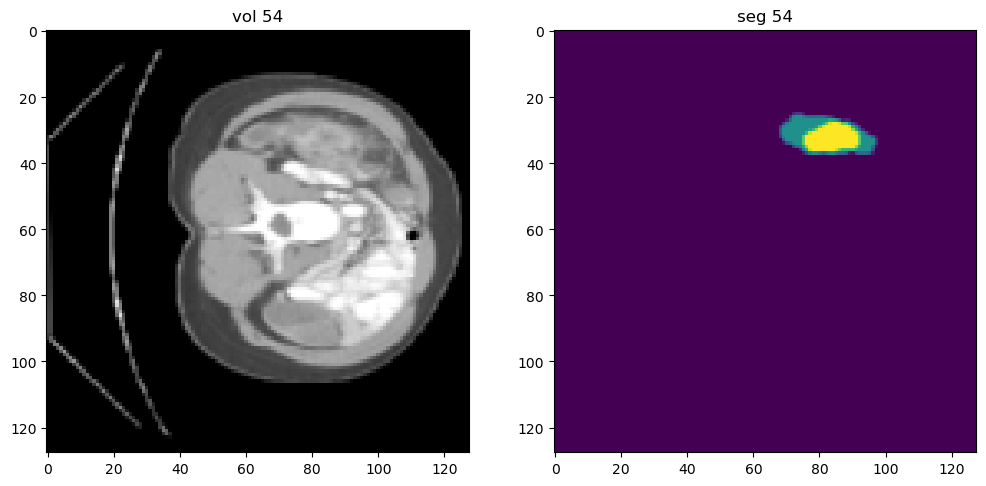

In [11]:
patient = prepare(in_dir)
show_patient(patient,54)

In [13]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [27]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch
#from preporcess import prepare
#from utilities import train


data_dir = 'C:/Users/HP/Desktop/Bitirme/TrNii'
model_dir = 'C:/Users/HP/Desktop/Bitirme/TrSonuclar' 
data_in = prepare(data_dir, cache=True)

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer, 100, model_dir)

Loading dataset: 100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


----------
epoch 1/100
1/147, Train_loss: 0.6045
Train_dice: 0.3955
2/147, Train_loss: 0.6067
Train_dice: 0.3933
3/147, Train_loss: 0.6064
Train_dice: 0.3936
4/147, Train_loss: 0.6047
Train_dice: 0.3953
5/147, Train_loss: 0.6035
Train_dice: 0.3965
6/147, Train_loss: 0.6053
Train_dice: 0.3947
7/147, Train_loss: 0.6050
Train_dice: 0.3950
8/147, Train_loss: 0.6033
Train_dice: 0.3967
9/147, Train_loss: 0.6032
Train_dice: 0.3968
10/147, Train_loss: 0.6062
Train_dice: 0.3938
11/147, Train_loss: 0.6047
Train_dice: 0.3953
12/147, Train_loss: 0.6051
Train_dice: 0.3949
13/147, Train_loss: 0.5981
Train_dice: 0.4019
14/147, Train_loss: 0.6056
Train_dice: 0.3944
15/147, Train_loss: 0.6053
Train_dice: 0.3947
16/147, Train_loss: 0.6054
Train_dice: 0.3946
17/147, Train_loss: 0.5967
Train_dice: 0.4033
18/147, Train_loss: 0.6058
Train_dice: 0.3942
19/147, Train_loss: 0.6045
Train_dice: 0.3955
20/147, Train_loss: 0.5969
Train_dice: 0.4031
21/147, Train_loss: 0.6042
Train_dice: 0.3958
22/147, Train_loss: 

In [44]:
train(model, data_in, loss_function, optimizer, 1, model_dir)

----------
epoch 1/1
1/147, Train_loss: 0.0125
Train_dice: 0.9875
2/147, Train_loss: 0.0164
Train_dice: 0.9836
3/147, Train_loss: 0.0164
Train_dice: 0.9836
4/147, Train_loss: 0.0241
Train_dice: 0.9759
5/147, Train_loss: 0.0137
Train_dice: 0.9863
6/147, Train_loss: 0.0186
Train_dice: 0.9814
7/147, Train_loss: 0.0178
Train_dice: 0.9822
8/147, Train_loss: 0.0225
Train_dice: 0.9775
9/147, Train_loss: 0.0226
Train_dice: 0.9774
10/147, Train_loss: 0.0139
Train_dice: 0.9861
11/147, Train_loss: 0.0189
Train_dice: 0.9811
12/147, Train_loss: 0.0145
Train_dice: 0.9855
13/147, Train_loss: 0.0253
Train_dice: 0.9747
14/147, Train_loss: 0.0232
Train_dice: 0.9768
15/147, Train_loss: 0.0267
Train_dice: 0.9733
16/147, Train_loss: 0.5004
Train_dice: 0.4996
17/147, Train_loss: 0.0221
Train_dice: 0.9779
18/147, Train_loss: 0.5004
Train_dice: 0.4996
19/147, Train_loss: 0.0173
Train_dice: 0.9827
20/147, Train_loss: 0.0150
Train_dice: 0.9850
21/147, Train_loss: 0.0148
Train_dice: 0.9852
22/147, Train_loss: 0.

In [17]:
print("CUDA Available:", torch.cuda.is_available())
print(torch.version.cuda)
print("CUDA Device Count:", torch.cuda.device_count())

CUDA Available: True
11.8
CUDA Device Count: 1


In [49]:
device = torch.device("cuda")

In [67]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [42]:
import torch

print(torch.version.cuda)  # Should return the CUDA version
print(torch.backends.cudnn.version())  # Should return the cuDNN version


11.8
8700
